In [1]:
from utils import split_half_reliability_clean
import numpy as np
import matplotlib.pyplot as plt
from utils import journal_figure
from scipy.stats import spearmanr
from utils import spearman_ci_boot, calculate_i1, split_half_reliability
import json
import pandas as pd
from scipy.signal import savgol_filter


In [2]:
selected_indices = [0, 2, 22, 25, 41, 44, 63, 68, 81, 85, 101, 120, 122, 140, 142, 161, 180, 187]
selected_indices_v2 = [8, 18, 24, 31, 46, 54, 70, 76, 86, 87, 102, 103, 105, 123, 130, 143, 144, 163, 172, 173, 191, 199]
all_selected_indices = list(sorted(selected_indices + selected_indices_v2))

In [3]:
def fisher_transform(r):
    z = 0.5 * np.log((1+r)/(1-r+ 1e-5))
    return z

In [4]:
import h5py

with h5py.File('coco_indices_in_python.mat', 'r') as f:
    print(list(f.keys()))  #
    indices_coco = f['coco_indices_in_python'][:]

indices_coco = np.array(indices_coco.squeeze(), dtype=int)

['coco_indices_in_python']


In [5]:
i1_humans = np.load("behavioral_responses/humans/i1_muri1320.npy")
reliabilities_humans = np.load("behavioral_responses/humans/reliabilities_muri1320.npy")

In [6]:
monkey_behavior = pd.read_csv("./psychophysics/monkey_muri1320.csv")
monkey_behavior_40 = monkey_behavior[monkey_behavior["image_number"].isin(all_selected_indices)]
i1_monkeys = calculate_i1(monkey_behavior, key="image_number")
i1_monkeys_coco = i1_monkeys[indices_coco]

reliabilities_monkeys_40 = []
for _ in range(10):
    r = split_half_reliability_clean(monkey_behavior_40, key="image_number")
    reliabilities_monkeys_40.append(r)

reliabilities_monkeys_40 = np.array(reliabilities_monkeys_40)

In [7]:
i1_monkeys_coco_ = fisher_transform(i1_monkeys_coco)

In [8]:
percentiles = np.array([50, 60, 70, 80, 90, 95])
accs_p = np.zeros((1, len(percentiles)))+np.nan
accs_p_err = np.zeros((1, len(percentiles)))+np.nan
corrs_p = np.zeros((1, len(percentiles)))+np.nan
corrs_p_err = np.zeros((1, len(percentiles)))+np.nan

accs_p_worst = np.zeros((1, len(percentiles)))+np.nan
accs_p_worst_err = np.zeros((1, len(percentiles)))+np.nan
corrs_p_worst = np.zeros((1, len(percentiles)))+np.nan
corrs_p_worst_err = np.zeros((1, len(percentiles)))+np.nan

# for r in range(20):
for p_idx, p in enumerate(percentiles):
    response_dir = f'./behavioral_responses/convnext/NoiseTunnel_Saliency'
    i1_file_ref = f'{response_dir}/{p}/convnext_i1.json'
    
    with open(i1_file_ref, 'r') as f:
        i1_scores_ref = json.load(f)
    
    i1_20 = np.array(i1_scores_ref['target_pEMI'])[all_selected_indices]
    i1_20_ = fisher_transform(i1_20)

    accs_p[0,p_idx] = i1_20.mean()
    accs_p_err[0,p_idx] = i1_20.std()/np.sqrt(len(i1_20))

    corr, el, eh = spearman_ci_boot(i1_20_, i1_monkeys_coco_[all_selected_indices])

    corrs_p[0,p_idx] = corr
    corrs_p_err[0,p_idx] = (el+eh)/2

    response_dir = f'./behavioral_responses/convnext/Deconvolution'
    i1_file_ref = f'{response_dir}/{p}/convnext_i1.json'

    with open(i1_file_ref, 'r') as f:
        i1_scores_ref = json.load(f)
    
    i1_20 = np.array(i1_scores_ref['target_pEMI'])[all_selected_indices]
    i1_20_ = fisher_transform(i1_20)

    accs_p_worst[0,p_idx] = i1_20.mean()
    accs_p_worst_err[0,p_idx] = i1_20.std()/np.sqrt(len(i1_20))

    corr, el, eh = spearman_ci_boot(i1_20_, i1_monkeys_coco_[all_selected_indices])

    corrs_p_worst[0,p_idx] = corr
    corrs_p_worst_err[0,p_idx] = (el+eh)/2

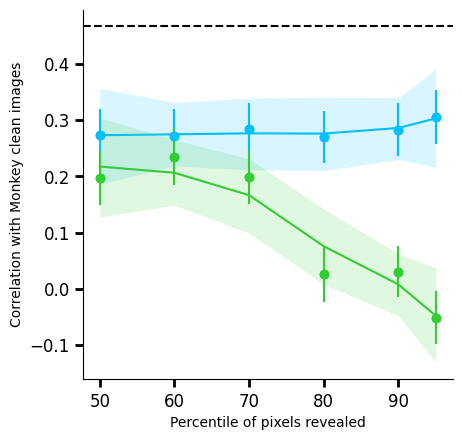

In [9]:
x = np.array(percentiles, dtype=float)
y = (np.nanmean(corrs_p, axis=0)/np.sqrt(np.nanmean(reliabilities_monkeys_40)))
yerr=(np.nanmean(corrs_p_err, axis=0)/np.sqrt(40))
plt.scatter(x, y, marker='o', color='deepskyblue')
plt.errorbar(x, y, yerr=yerr, marker='o', color='deepskyblue', linestyle="None")

order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="deepskyblue")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="deepskyblue", alpha=0.15, linewidth=0)

y = (np.nanmean(corrs_p_worst, axis=0)/np.sqrt(np.nanmean(reliabilities_monkeys_40)))
yerr=(np.nanmean(corrs_p_worst_err, axis=0)/np.sqrt(40))
plt.scatter(x, y, marker='o', color='limegreen')
plt.errorbar(x, y, yerr=yerr, marker='o', color='limegreen', linestyle="None")

y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="limegreen")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="limegreen", alpha=0.15, linewidth=0)

plt.axhline(spearmanr(i1_monkeys_coco_[all_selected_indices], i1_humans[indices_coco][all_selected_indices])[0]/np.sqrt(np.nanmean(reliabilities_humans)*np.nanmean(reliabilities_monkeys_40)), color="black", linestyle="--")
plt.xlabel("Percentile of pixels revealed")
plt.ylabel("Correlation with Monkey clean images")

journal_figure()